In [2]:
import gym
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import random
from itertools import count

In [3]:
class DQN(nn.Module):
  def __init__(self,observations, actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(observations, 128)
    self.layer2 = nn.Linear(128, 256)
    #self.layer3 = nn.Linear(256, 512)
    self.layer3 = nn.Linear(256, actions)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    #x = F.relu(self.layer3(x))
    x = self.layer3(x)

    return x

In [4]:
from collections import namedtuple

#named tuple which represent the transition in gym env
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory: #Buffer that holds the observed transitions
  def __init__(self, capacity):
    self.memory = deque(maxlen = capacity)

  def push(self, state, action, reward, next_state, done):
    self.memory.append(Transition(state, action, reward, next_state, done))

  #def push(self, *args):
    #self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
torch.cuda.is_available()

False

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nbconvert
!jupyter nbconvert --to python '/content/drive/My Drive/Colab/environment.ipynb'

In [8]:
import sys
sys.path.append('/content/drive/My Drive/Colab')
from environment import GodOfWar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.6 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/
/content/drive/MyDrive/RL1/images


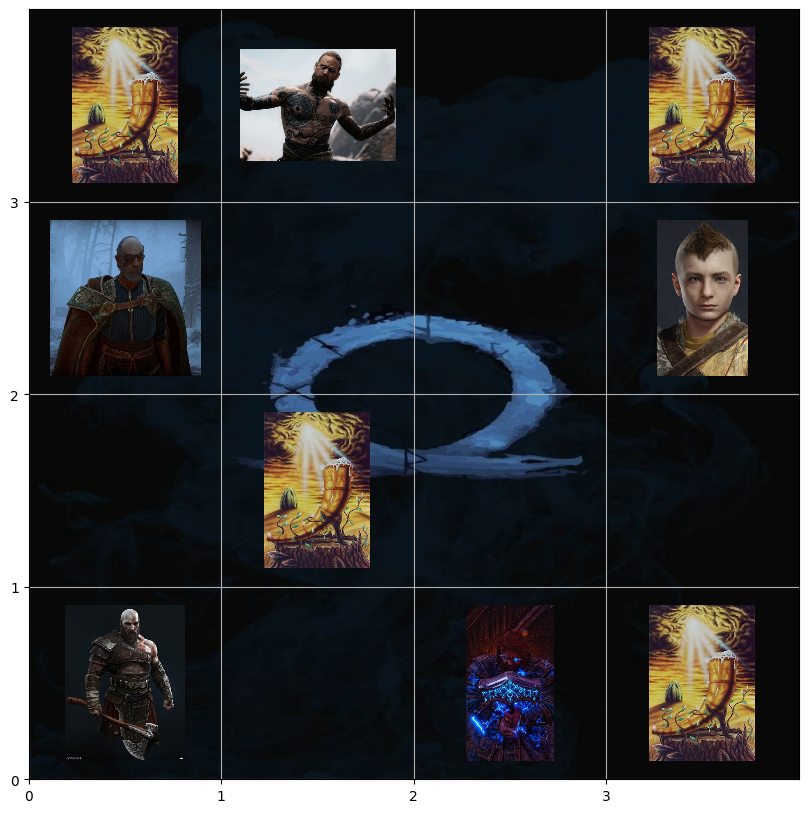

In [9]:
env = GodOfWar()
env.reset()
env.render(plot=True)

In [10]:
print(env.action_space.n)

4


In [11]:
#Function to select action according to the epsilon greedy policy
def epsilon_greedy(state, epsilon=0.1):
    global steps_done
    sample = random.random()
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Random action
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)


Complete


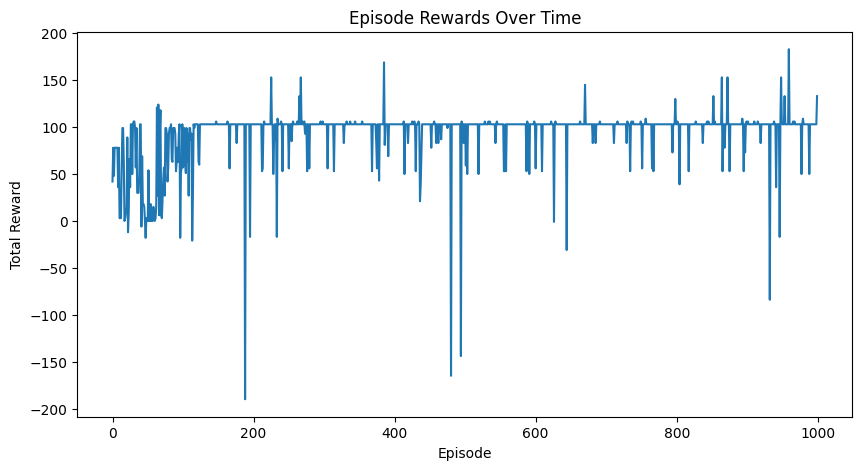

In [13]:
env = GodOfWar()

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQN(16, 4).to(device)
target_net = DQN(16, 4).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

#Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

#Replay memory
memory = ReplayMemory(10000)

#Training hyperparameters
num_episodes = 1000
batch_size = 128
min_epsilon = 0.01
gamma = 0.99
epsilon_decay = 0.9952
target_update = 10
epsilon = 1.0

def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    #Convert batch-array of Transitions to Transition of batch-arrays
    non_final_next_states = torch.cat([s.next_state for s in transitions if s.next_state is not None])
    state_batch = torch.cat([s.state for s in transitions])
    action_batch = torch.cat([s.action for s in transitions])
    reward_batch = torch.cat([s.reward for s in transitions])

    #Boolean mask
    non_final_mask = torch.tensor(tuple(map(lambda s: s.next_state is not None, transitions)), device=device, dtype=torch.bool)

    state_action_values = policy_net(state_batch).gather(1, action_batch)#.unsqueeze(-1))
    action_batch = action_batch.unsqueeze(0)
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


steps_done = 0
episode_rewards = []
epsilon_history = []
for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)

    total_reward = 0

    for t in count():

        steps_done += 1
        action = epsilon_greedy(state)
        next_state, reward, done, _ = env.step(action.item())
        total_reward += reward

        #Process the next state
        next_state = torch.tensor([next_state], device=device, dtype=torch.float)

        #Store the transition in memory
        memory.push(state, action, torch.tensor([reward], device=device), next_state, torch.tensor([done], device=device))

        state = next_state
        optimize_model()

        if done:
            episode_rewards.append(total_reward)
            break

    #Updating the target network
    if i_episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(min_epsilon, epsilon*epsilon_decay)
    epsilon_history.append(epsilon)

#Saving the model
torch.save(policy_net.state_dict(), 'godofwar_dqn.pth')
print('Complete')

plt.figure(figsize=(10,5))
plt.plot(episode_rewards)
plt.title('Episode Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


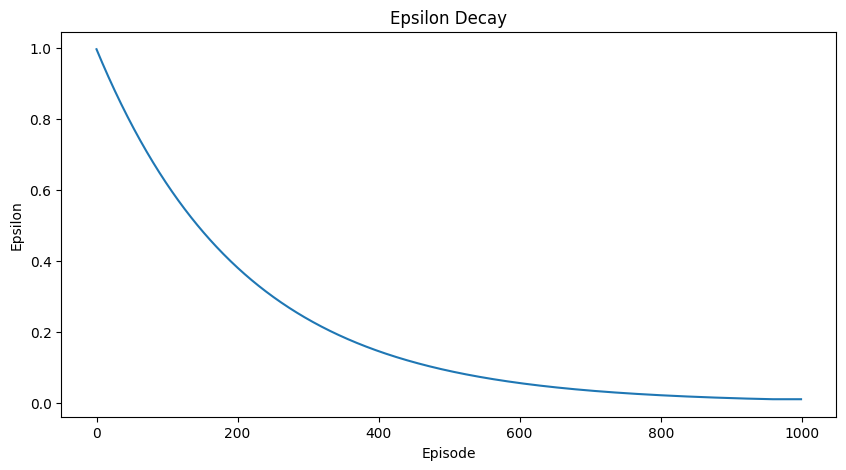

In [14]:
plt.figure(figsize=(10,5))
plt.plot(epsilon_history)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [15]:
PATH = "/content/drive/My Drive/Colab/policy_net_GodOfWar.pth"
torch.save(policy_net.state_dict(), PATH)

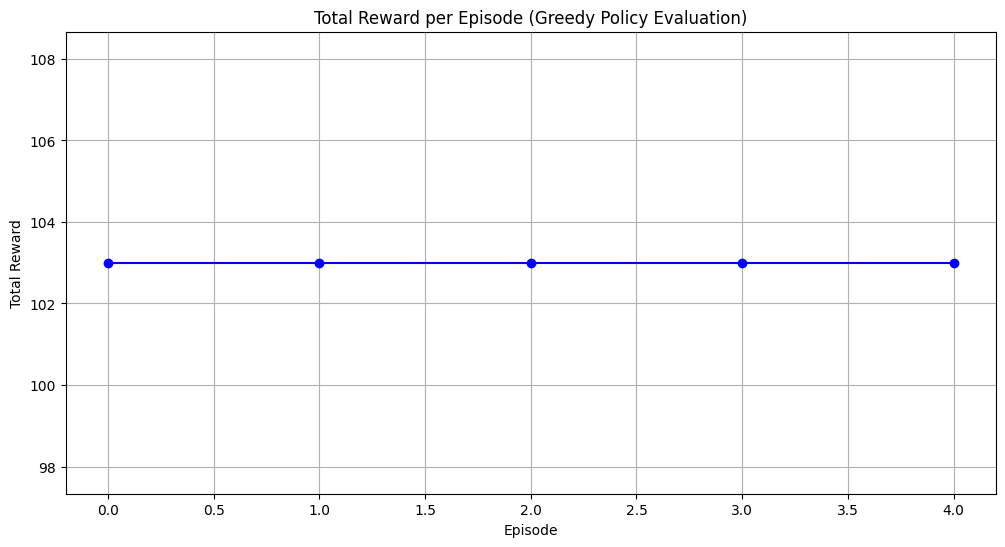

In [22]:
env = GodOfWar()

def select_greedy_action(state, policy_net):
    with torch.no_grad():
        action_values = policy_net(state)
        #return action_values.max(1)[1]
        return action_values.max(1)[1].view(1, 1)
        #return action_values.max(1)[1].view(1, 1)

def evaluate_policy(env, policy_net, num_episodes, device):
    rewards_per_episode = []
    policy_net.eval()

    for i_episode in range(num_episodes):
        state= env.reset()
        state = torch.tensor([state], dtype=torch.float32, device=device)#.unsqueeze(0)

        total_reward = 0

        for t in count():
            action = select_greedy_action(state, policy_net)
            observation, reward,  done, info  = env.step(action.item())
            next_state = torch.tensor([observation], dtype=torch.float32, device=device)

            state = next_state if not done else None
            total_reward += reward

            if done:
                break

        rewards_per_episode.append(total_reward)

    return rewards_per_episode

#Loading trained policy:
PATH = "/content/drive/My Drive/Colab/policy_net_GodOfWar.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(16, 4).to(device)
policy_net.load_state_dict(torch.load(PATH, map_location=device))

num_evaluation_episodes = 5
reward_per_episode = evaluate_policy(env, policy_net, num_evaluation_episodes, device)

#Plot
plt.figure(figsize=(12, 6))
plt.plot(reward_per_episode, marker='o', linestyle='-', color='blue')
plt.title('Total Reward per Episode (Greedy Policy Evaluation)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# References

1. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

2. https://datascience.stackexchange.com/questions/118503/how-to-use-function-from-other-colab-file

3. https://medium.com/@vignesh.g1609/deep-q-learning-dqn-using-pytorch-a31f02a910ac

4. https://discuss.pytorch.org/t/calculating-various-outputs-at-the-same-time-in-reinforcement-learning-tutorial/119419

5. https://github.com/jmichaux/dqn-pytorch/blob/master/main.py

6. https://github.com/mrakgr/Python-Projects/blob/master/PyTorch%20Tutorials/reinforcement_q_learning.py